# CHURN PREDICTION OF TELECOM CUSTOMER

## Load libraries

In [1]:
!pip install pandas==0.25.3
!pip install --user pandas_ml==0.6.1
#downgrade matplotlib to bypass issue with confusion matrix being chopped out
!pip install matplotlib==3.1.0
!pip install --user scikit-learn==0.22.2
!pip install -q scikit-plot

     |████████████████████████████████| 7.1 MB 13.0 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [2]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn import metrics
import pickle

## Dataset Loading

In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_aab26c6fee90400a8517f7fc95364cea = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='E3q7F4evBSeRcwxt6Rc22PKOts3IFf52pmaZI2im-_wk',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_aab26c6fee90400a8517f7fc95364cea.get_object(Bucket='projecttelecomcustomerchurnpredic-donotdelete-pr-brwls5rnnqghjw',Key='Churn_Modelling.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
customer_data = df_data_1

In [5]:
# Checking that everything is correct
pd.set_option('display.max_columns', 30)
customer_data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [6]:
# After running this cell we will see that we have no missing values
customer_data.info()
customer_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


(10000, 14)

In [7]:
# Drop customerID column
customer_data = customer_data.drop('RowNumber', axis=1)
customer_data = customer_data.drop('CustomerId', axis=1)
customer_data = customer_data.drop('Surname', axis=1)
customer_data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
# Check if we have any NaN values
customer_data.isnull().values.any()

False

In [9]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [10]:
# Describe columns with numerical values
pd.set_option('precision', 3)
customer_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204
std,96.653,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000
max,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


In [11]:
# Describe columns with objects
customer_data.describe(exclude=np.number)

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [12]:
# Find correlations
customer_data.corr(method='pearson')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000e+00,-0.004,8.419e-04,0.006,0.012,-0.005,0.026,-0.001,-0.027
Age,-3.965e-03,1.000,-9.997e-03,0.028,-0.031,-0.012,0.085,-0.007,0.285
Tenure,8.419e-04,-0.010,1.000e+00,-0.012,0.013,0.023,-0.028,0.008,-0.014
Balance,6.268e-03,0.028,-1.225e-02,1.000,-0.304,-0.015,-0.010,0.013,0.119
NumOfProducts,1.224e-02,-0.031,1.344e-02,-0.304,1.000,0.003,0.010,0.014,-0.048
HasCrCard,-5.458e-03,-0.012,2.258e-02,-0.015,0.003,1.000,-0.012,-0.010,-0.007
IsActiveMember,2.565e-02,0.085,-2.836e-02,-0.010,0.010,-0.012,1.000,-0.011,-0.156
EstimatedSalary,-1.384e-03,-0.007,7.784e-03,0.013,0.014,-0.010,-0.011,1.000,0.012
Exited,-2.709e-02,0.285,-1.400e-02,0.119,-0.048,-0.007,-0.156,0.012,1.000


Each category within the gender column has the following count : 
Gender
Female    4543
Male      5457
dtype: int64


Text(0, 0.5, 'Frequency')

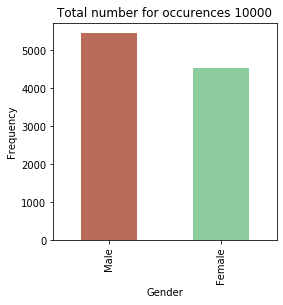

In [13]:
df_churn_pd = customer_data
print( "Each category within the gender column has the following count : ")
print(df_churn_pd.groupby(['Gender']).size())
#bar chart to show split of data
index = ['Male','Female']
churn_plot = df_churn_pd['Gender'].value_counts(sort=True, ascending=False).plot(kind='bar',
            figsize=(4,4),title="Total number for occurences " 
            + str(df_churn_pd['Gender'].count()), color=['#BB6B5A','#8CCB9B'])
churn_plot.set_xlabel("Gender")
churn_plot.set_ylabel("Frequency")

Each category within the gender column has the following count : 
Geography
France     5014
Germany    2509
Spain      2477
dtype: int64


Text(0, 0.5, 'Frequency')

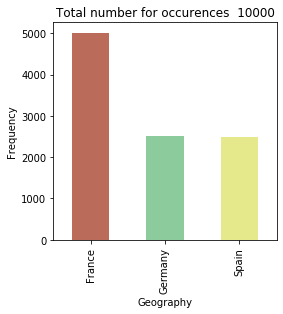

In [14]:
print( "Each category within the gender column has the following count : ")
print(df_churn_pd.groupby(['Geography']).size())
#bar chart to show split of data
index = ['France','Germany','Spain']
churn_plot = df_churn_pd['Geography'].value_counts(sort=True, ascending=False).plot(kind='bar',
            figsize=(4,4),title="Total number for occurences  " 
            + str(df_churn_pd['Geography'].count()), color=['#BB6B5A','#8CCB9B','#E5E88B'])
churn_plot.set_xlabel("Geography")
churn_plot.set_ylabel("Frequency")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/seaborn/axisgrid.py:100: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f6e0d2171d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


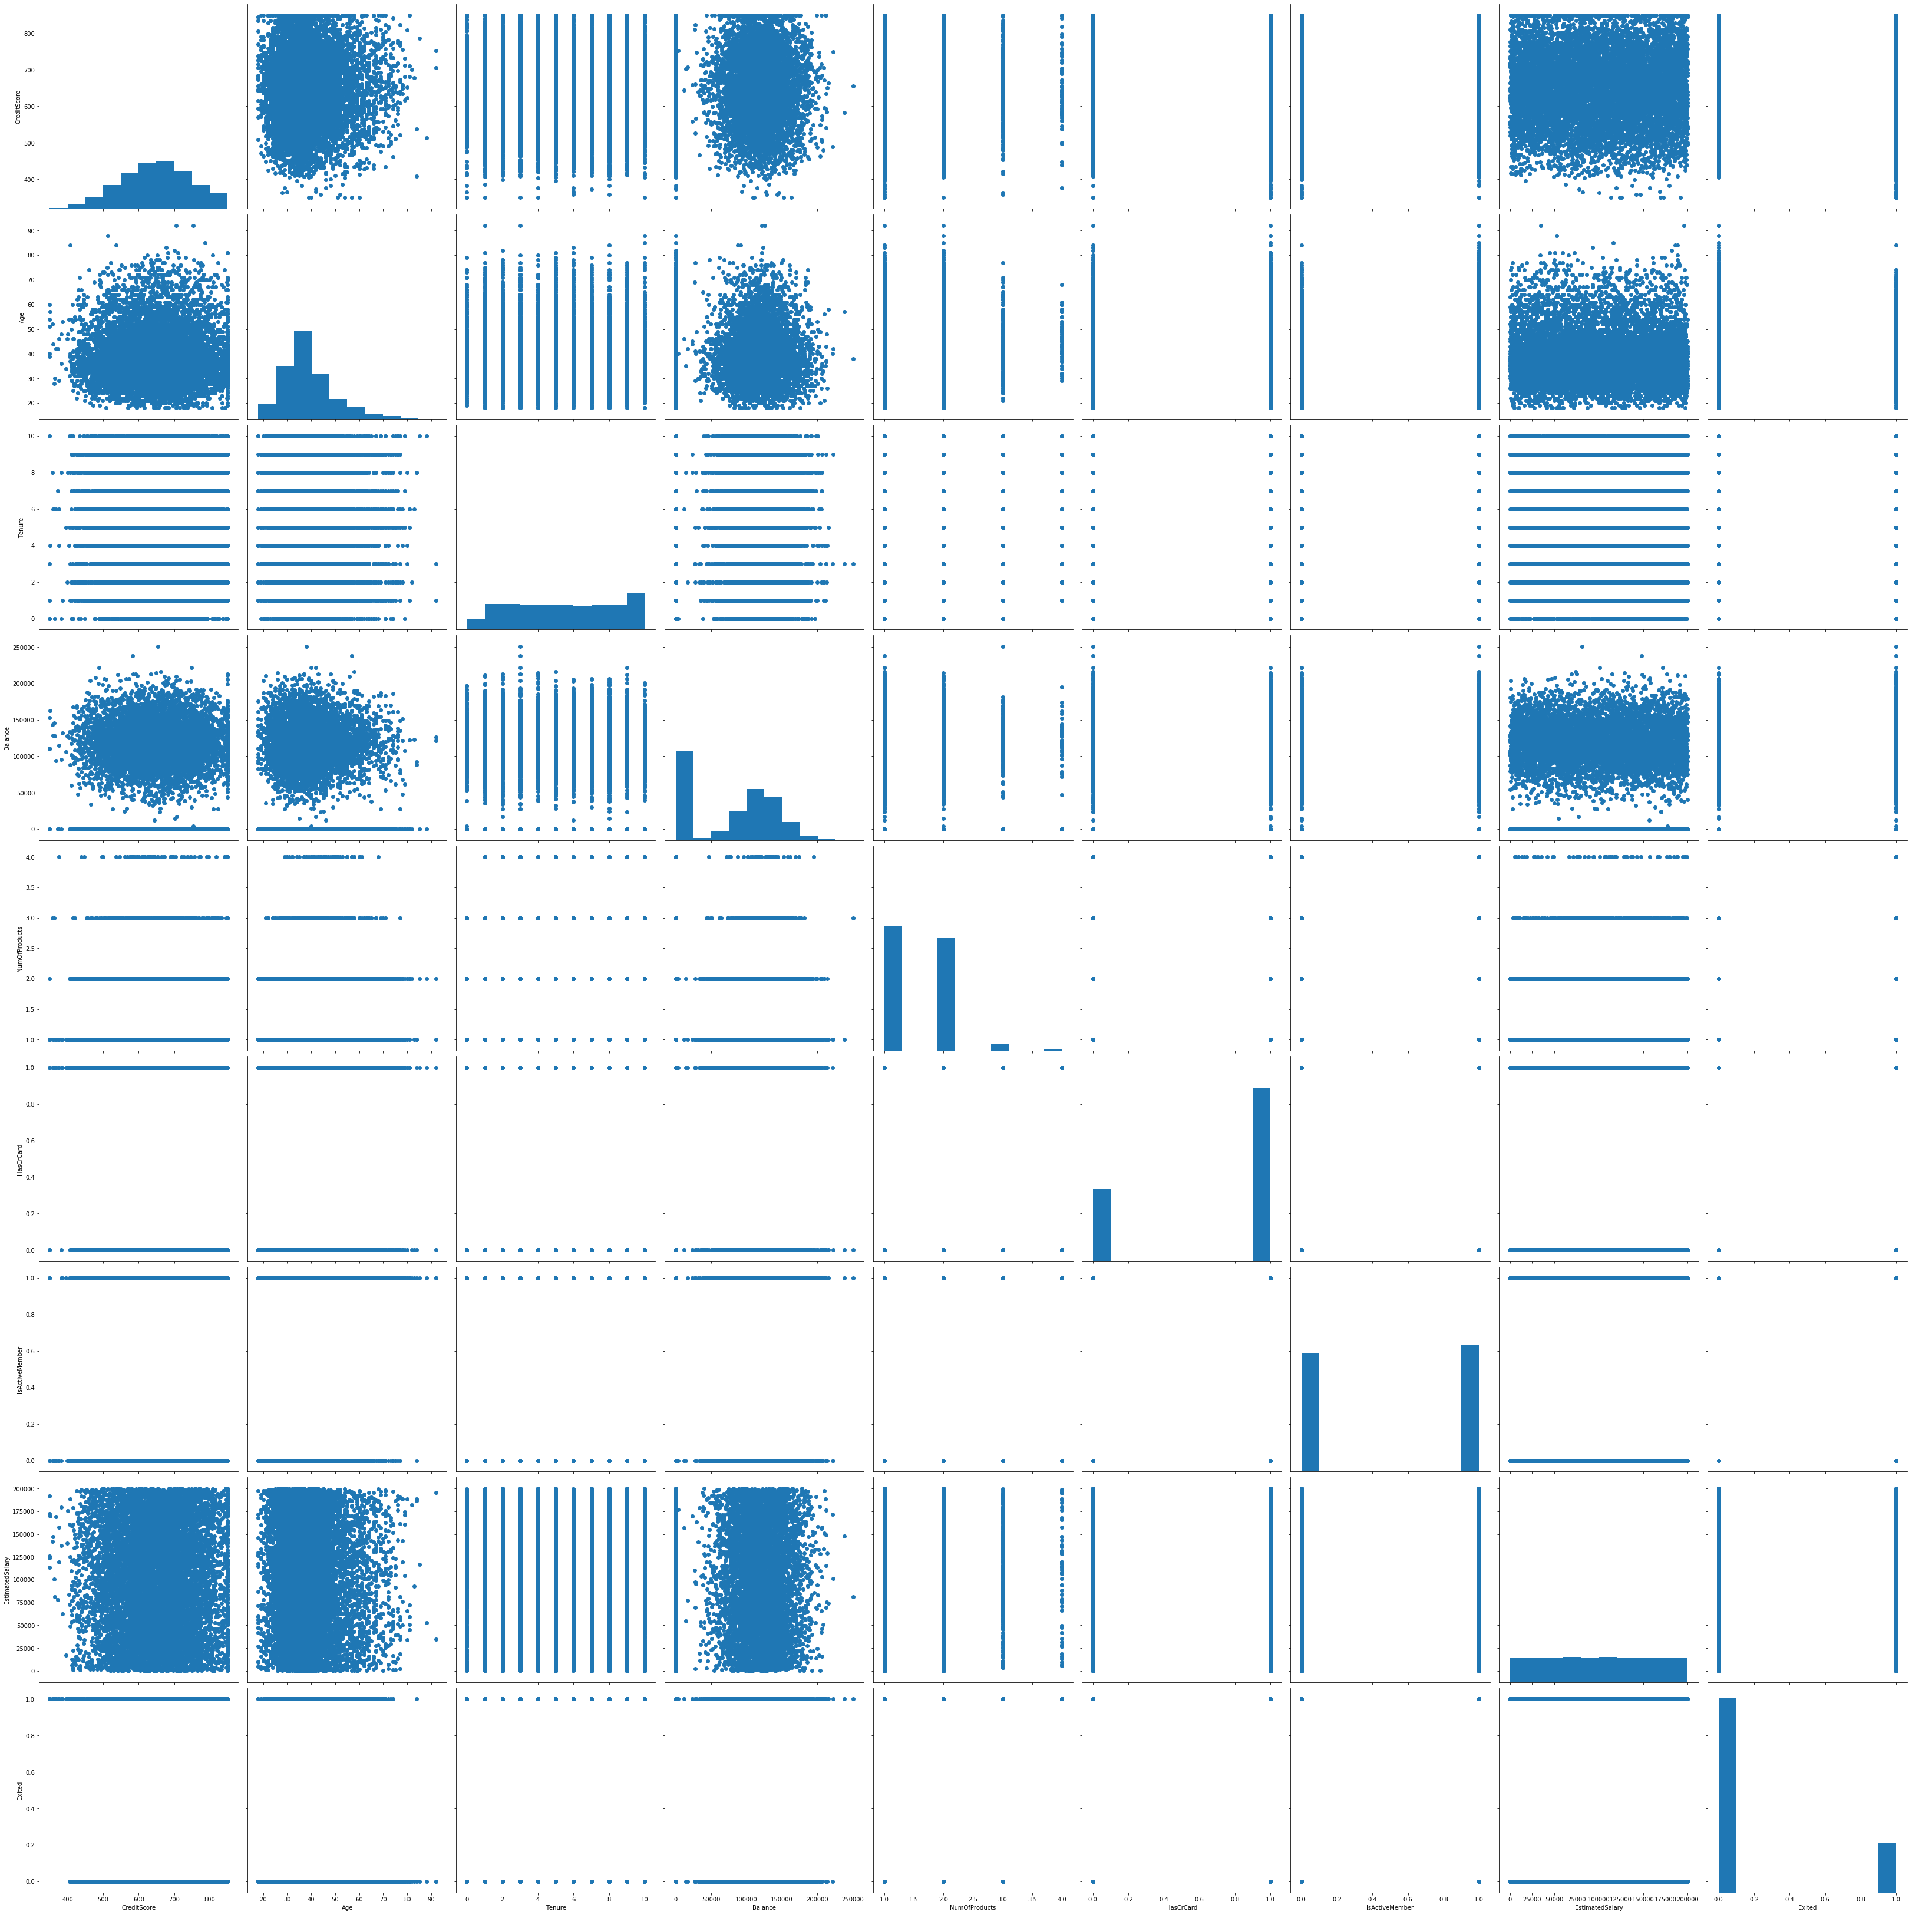

In [15]:
# Create Grid for pairwise relationships
gr = sns.PairGrid(customer_data, height=5)
gr = gr.map_diag(plt.hist)
gr = gr.map_offdiag(plt.scatter)
gr = gr.add_legend()

In [104]:
customer_data1 = customer_data
customer_data1 = customer_data1.drop('Exited', axis=1)
customer_data1.head(5)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [105]:
# Use pandas get_dummies
customer_data_encoded = pd.get_dummies(customer_data1)
print(customer_data_encoded.head(10))
customer_data_encoded.shape

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   
5          645   44       8  113755.78              2          1   
6          822   50       7       0.00              2          1   
7          376   29       4  115046.74              4          1   
8          501   44       4  142051.07              2          0   
9          684   27       2  134603.88              1          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1        101348.88                 1                  0   
1               1        112542.58                 0                  0   
2               0        1

(10000, 13)

In [106]:
# Create training data for non-preprocessed approach
X_npp = customer_data.iloc[:, :-1].apply(LabelEncoder().fit_transform)
pd.DataFrame(X_npp).head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228,0,0,24,2,0,0,1,1,5068
1,217,2,0,23,1,743,0,0,1,5639
2,111,0,0,24,8,5793,2,1,0,5707
3,308,0,0,21,1,0,1,0,0,4704
4,459,2,0,25,2,3696,0,1,1,3925


In [107]:
# Create training data for that will undergo preprocessing
X = customer_data_encoded
X.head()
print(X.shape)

(10000, 13)


In [108]:
# Extract labels
y_unenc = customer_data['Exited']

In [109]:
# Convert strings of 'yes' and 'no' to binary values of 0 or 1
le = preprocessing.LabelEncoder()
le.fit(y_unenc)

y_le = le.transform(y_unenc)
pd.DataFrame(y_le)

,0
0,1
1,0
2,1
3,0
4,0
...,...
9995,0
9996,0
9997,1
9998,1


In [110]:
# Calculate the Z-score using median value and median absolute deviation for more robust calculations
# Working on EstimatedSalary column
threshold = 3

median = np.median(X['EstimatedSalary'])
median_absolute_deviation = np.median([np.abs(x - median) for x in X['EstimatedSalary']])
modified_z_scores = [0.6745 * (x - median) / median_absolute_deviation
                         for x in X['EstimatedSalary']]
results = np.abs(modified_z_scores) > threshold

print(np.any(results))

False


In [111]:
# Do the same for Balance column but using the interquartile method

quartile_1, quartile_3 = np.percentile(X['Balance'], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)

print(np.where((X['Balance'] > upper_bound) | (X['Balance'] < lower_bound)))

(array([], dtype=int64),)


In [112]:
print(X)
X.shape

      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42       2       0.00              1          1   
1             608   41       1   83807.86              1          0   
2             502   42       8  159660.80              3          1   
3             699   39       1       0.00              2          0   
4             850   43       2  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39       5       0.00              2          1   
9996          516   35      10   57369.61              1          1   
9997          709   36       7       0.00              1          0   
9998          772   42       3   75075.31              2          1   
9999          792   28       4  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0                  1        101348.88                 1              

(10000, 13)

In [113]:

# Find interactions between current features and append them to the dataframe
def add_interactions(dataset):
    # Get feature names
    comb = list(combinations(list(dataset.columns), 2))
    col_names = list(dataset.columns) + ['_'.join(x) for x in comb]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    dataset = poly.fit_transform(dataset)
    dataset = pd.DataFrame(dataset)
    dataset.columns = col_names
    
    # Remove interactions with 0 values
    no_inter_indexes = [i for i, x in enumerate(list((dataset ==0).all())) if x]
    dataset = dataset.drop(dataset.columns[no_inter_indexes], axis=1)
    
    return dataset

print(X)
X.shape

      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42       2       0.00              1          1   
1             608   41       1   83807.86              1          0   
2             502   42       8  159660.80              3          1   
3             699   39       1       0.00              2          0   
4             850   43       2  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39       5       0.00              2          1   
9996          516   35      10   57369.61              1          1   
9997          709   36       7       0.00              1          0   
9998          772   42       3   75075.31              2          1   
9999          792   28       4  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0                  1        101348.88                 1              

(10000, 13)

In [114]:
X_inter = add_interactions(X)
X_inter.head(15)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CreditScore_Age,CreditScore_Tenure,...,IsActiveMember_Geography_Germany,IsActiveMember_Geography_Spain,IsActiveMember_Gender_Female,IsActiveMember_Gender_Male,EstimatedSalary_Geography_France,EstimatedSalary_Geography_Germany,EstimatedSalary_Geography_Spain,EstimatedSalary_Gender_Female,EstimatedSalary_Gender_Male,Geography_France_Gender_Female,Geography_France_Gender_Male,Geography_Germany_Gender_Female,Geography_Germany_Gender_Male,Geography_Spain_Gender_Female,Geography_Spain_Gender_Male
0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0,0.0,0.0,1.0,0.0,25998.0,1238.0,...,0.0,0.0,1.0,0.0,101348.88,0.00,0.00,101348.88,0.00,1.0,0.0,0.0,0.0,0.0,0.0
1,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,0.0,1.0,1.0,0.0,24928.0,608.0,...,0.0,1.0,1.0,0.0,0.00,0.00,112542.58,112542.58,0.00,0.0,0.0,0.0,0.0,1.0,0.0
2,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,0.0,0.0,1.0,0.0,21084.0,4016.0,...,0.0,0.0,0.0,0.0,113931.57,0.00,0.00,113931.57,0.00,1.0,0.0,0.0,0.0,0.0,0.0
3,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,1.0,0.0,0.0,1.0,0.0,27261.0,699.0,...,0.0,0.0,0.0,0.0,93826.63,0.00,0.00,93826.63,0.00,1.0,0.0,0.0,0.0,0.0,0.0
4,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,0.0,1.0,1.0,0.0,36550.0,1700.0,...,0.0,1.0,1.0,0.0,0.00,0.00,79084.10,79084.10,0.00,0.0,0.0,0.0,0.0,1.0,0.0
5,645.0,44.0,8.0,113755.78,2.0,1.0,0.0,149756.71,0.0,0.0,1.0,0.0,1.0,28380.0,5160.0,...,0.0,0.0,0.0,0.0,0.00,0.00,149756.71,0.00,149756.71,0.0,0.0,0.0,0.0,0.0,1.0
6,822.0,50.0,7.0,0.00,2.0,1.0,1.0,10062.80,1.0,0.0,0.0,0.0,1.0,41100.0,5754.0,...,0.0,0.0,0.0,1.0,10062.80,0.00,0.00,0.00,10062.80,0.0,1.0,0.0,0.0,0.0,0.0
7,376.0,29.0,4.0,115046.74,4.0,1.0,0.0,119346.88,0.0,1.0,0.0,1.0,0.0,10904.0,1504.0,...,0.0,0.0,0.0,0.0,0.00,119346.88,0.00,119346.88,0.00,0.0,0.0,1.0,0.0,0.0,0.0
8,501.0,44.0,4.0,142051.07,2.0,0.0,1.0,74940.50,1.0,0.0,0.0,0.0,1.0,22044.0,2004.0,...,0.0,0.0,0.0,1.0,74940.50,0.00,0.00,0.00,74940.50,0.0,1.0,0.0,0.0,0.0,0.0
9,684.0,27.0,2.0,134603.88,1.0,1.0,1.0,71725.73,1.0,0.0,0.0,0.0,1.0,18468.0,1368.0,...,0.0,0.0,0.0,1.0,71725.73,0.00,0.00,0.00,71725.73,0.0,1.0,0.0,0.0,0.0,0.0


In [115]:
# Select best features
select = sklearn.feature_selection.SelectKBest(k=25)
selected_features = select.fit(X_inter, y_le)
indexes = selected_features.get_support(indices=True)
col_names_selected = [X_inter.columns[i] for i in indexes]

X_selected = X_inter[col_names_selected]
X_selected.head(10)

,Age,Balance,IsActiveMember,Geography_Germany,CreditScore_Age,CreditScore_IsActiveMember,CreditScore_Geography_Germany,Age_Balance,Age_NumOfProducts,Age_EstimatedSalary,Age_Geography_Germany,Age_Gender_Female,Tenure_IsActiveMember,Tenure_Geography_Germany,Balance_NumOfProducts,Balance_Geography_Germany,Balance_Gender_Female,NumOfProducts_IsActiveMember,NumOfProducts_Geography_Germany,HasCrCard_IsActiveMember,HasCrCard_Geography_Germany,IsActiveMember_Geography_France,IsActiveMember_Gender_Male,EstimatedSalary_Geography_Germany,Geography_Germany_Gender_Female
0,42.0,0.00,1.0,0.0,25998.0,619.0,0.0,0.000e+00,42.0,4.257e+06,0.0,42.0,2.0,0.0,0.00,0.00,0.00,1.0,0.0,1.0,0.0,1.0,0.0,0.00,0.0
1,41.0,83807.86,1.0,0.0,24928.0,608.0,0.0,3.436e+06,41.0,4.614e+06,0.0,41.0,1.0,0.0,83807.86,0.00,83807.86,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,42.0,159660.80,0.0,0.0,21084.0,0.0,0.0,6.706e+06,126.0,4.785e+06,0.0,42.0,0.0,0.0,478982.40,0.00,159660.80,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,39.0,0.00,0.0,0.0,27261.0,0.0,0.0,0.000e+00,78.0,3.659e+06,0.0,39.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,43.0,125510.82,1.0,0.0,36550.0,850.0,0.0,5.397e+06,43.0,3.401e+06,0.0,43.0,2.0,0.0,125510.82,0.00,125510.82,1.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0
5,44.0,113755.78,0.0,0.0,28380.0,0.0,0.0,5.005e+06,88.0,6.589e+06,0.0,0.0,0.0,0.0,227511.56,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
6,50.0,0.00,1.0,0.0,41100.0,822.0,0.0,0.000e+00,100.0,5.031e+05,0.0,0.0,7.0,0.0,0.00,0.00,0.00,2.0,0.0,1.0,0.0,1.0,1.0,0.00,0.0
7,29.0,115046.74,0.0,1.0,10904.0,0.0,376.0,3.336e+06,116.0,3.461e+06,29.0,29.0,0.0,4.0,460186.96,115046.74,115046.74,0.0,4.0,0.0,1.0,0.0,0.0,119346.88,1.0
8,44.0,142051.07,1.0,0.0,22044.0,501.0,0.0,6.250e+06,88.0,3.297e+06,0.0,0.0,4.0,0.0,284102.14,0.00,0.00,2.0,0.0,0.0,0.0,1.0,1.0,0.00,0.0
9,27.0,134603.88,1.0,0.0,18468.0,684.0,0.0,3.634e+06,27.0,1.937e+06,0.0,0.0,2.0,0.0,134603.88,0.00,0.00,1.0,0.0,1.0,0.0,1.0,1.0,0.00,0.0


In [171]:
X_train_npp, X_test_npp, y_train_npp, y_test_npp = train_test_split(X_npp, y_unenc,\
                                                    test_size=0.33, random_state=42)
print(X_train_npp.shape, y_train_npp.shape)
print(X_test_npp.shape, y_test_npp.shape)

(6700, 10) (6700,)
(3300, 10) (3300,)


In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y_unenc,\
                                                    test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6700, 13) (6700,)
(3300, 13) (3300,)


In [173]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6252,596,32,3,96709.07,2,0,0,41788.37,0,1,0,0,1
4684,623,43,1,0.00,2,1,1,146379.30,1,0,0,0,1
1731,601,44,4,0.00,2,1,0,58561.31,0,0,1,1,0
4742,506,59,8,119152.10,2,1,1,170679.74,0,1,0,0,1
4521,560,27,7,124995.98,1,1,1,114669.79,0,0,1,1,0


In [174]:
# Use StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)

pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.676,-0.942,0.009,0.479,-0.905,-1.546,-1.036,1.505,-1.004,1.749,-0.58,1.100,-1.100
1,0.303,-0.180,1.047,-0.047,0.820,0.647,0.966,-1.312,-1.004,1.749,-0.58,-0.909,0.909
2,-0.102,0.963,-0.337,0.712,-0.905,0.647,-1.036,-1.321,-1.004,1.749,-0.58,-0.909,0.909
3,-0.414,-0.751,1.047,0.669,-0.905,0.647,0.966,-0.812,0.996,-0.572,-0.58,1.100,-1.100
4,-0.685,-0.561,1.393,-1.216,-0.905,0.647,-1.036,-1.629,0.996,-0.572,-0.58,-0.909,0.909


In [175]:
pd.DataFrame(y_train).head()

,Exited
8371,1
5027,0
9234,1
3944,0
6862,0


In [176]:
from sklearn.svm import SVC

# Run classifier
clf_svc_npp = svm.SVC(random_state=42)
clf_svc_npp.fit(X_train_npp, y_train_npp)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [177]:
from sklearn.linear_model import LogisticRegression

# Run classifier
clf_svc = svm.SVC(random_state=42)
clf_svc.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [178]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
model = clf_lr.fit(X_train_scaled, y_train)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [212]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(verbose=0,max_iter=600)
clf_mlp.fit(X_train_scaled, y_train)


# Note: MLP as a NN, can use data without the feature engineering step, as the NN will handle that automatically

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=600,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

In [213]:
# Use the scaler fit on trained data to scale our test data
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_test_scaled, columns=X_train.columns).head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.581,-0.656,-0.682,0.329,0.820,-1.546,-1.036,-1.026,-1.004,1.749,-0.580,-0.909,0.909
1,-0.300,0.392,-1.374,-1.216,0.820,0.647,0.966,0.785,0.996,-0.572,-0.580,-0.909,0.909
2,-0.529,0.487,-0.337,-1.216,0.820,0.647,-1.036,-0.736,-1.004,-0.572,1.725,1.100,-1.100
3,-1.517,1.916,1.047,0.688,0.820,0.647,0.966,1.205,-1.004,1.749,-0.580,-0.909,0.909
4,-0.955,-1.132,0.701,0.781,-0.905,0.647,0.966,0.236,-1.004,-0.572,1.725,1.100,-1.100


In [214]:
# Predict confidence scores for data
y_score_svc_npp = clf_svc_npp.decision_function(X_test_npp)
pd.DataFrame(y_score_svc_npp)

,0
0,-1.000
1,-1.000
2,-1.000
3,-0.999
4,-1.000
...,...
3295,-1.000
3296,-1.000
3297,-1.000
3298,-1.000


In [215]:
# Get accuracy score
from sklearn.metrics import accuracy_score
y_pred_svc_npp = clf_svc_npp.predict(X_test_npp)
acc_svc_npp = accuracy_score(y_test_npp, y_pred_svc_npp)
print(acc_svc_npp)

0.8051515151515152


In [216]:
# Get Precision vs. Recall score
from sklearn.metrics import average_precision_score
average_precision_svc_npp = average_precision_score(y_test_npp, y_score_svc_npp)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_svc_npp))

Average precision-recall score: 0.24


In [217]:
# Get model confidence of predictions
y_score_svc = clf_svc.decision_function(X_test_scaled)
y_score_svc

array([-1.35894336, -1.13050684, -1.01055346, ..., -1.30490437,
       -0.8450336 ,  0.98776799])

In [218]:
# Get accuracy score
y_pred_svc = clf_svc.predict(X_test_scaled)
acc_svc = accuracy_score(y_test, y_pred_svc)
print(acc_svc)

0.8615151515151516


In [219]:
# Get Precision vs. Recall score
average_precision_svc = average_precision_score(y_test, y_score_svc)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_svc))

Average precision-recall score: 0.66


In [220]:
y_score_lr = clf_lr.decision_function(X_test_scaled)
y_score_lr

array([-1.08106837, -2.43814741, -0.7665707 , ..., -1.49166938,
       -0.88480817,  0.46314123])

In [221]:
y_pred_lr = clf_lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(acc_lr)

0.8115151515151515


In [222]:
average_precision_lr = average_precision_score(y_test, y_score_lr)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_lr))

Average precision-recall score: 0.46


In [223]:
y_score_mlp = clf_mlp.predict_proba(X_test_scaled)[:, 1]
y_score_mlp

array([0.015341  , 0.01182332, 0.04388985, ..., 0.34860656, 0.37752165,
       0.83314618])

In [224]:
y_pred_mlp = clf_mlp.predict(X_test_scaled)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print(acc_mlp)

0.8569696969696969


In [225]:
average_precision_mlp = average_precision_score(y_test, y_score_mlp)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_mlp))

Average precision-recall score: 0.66


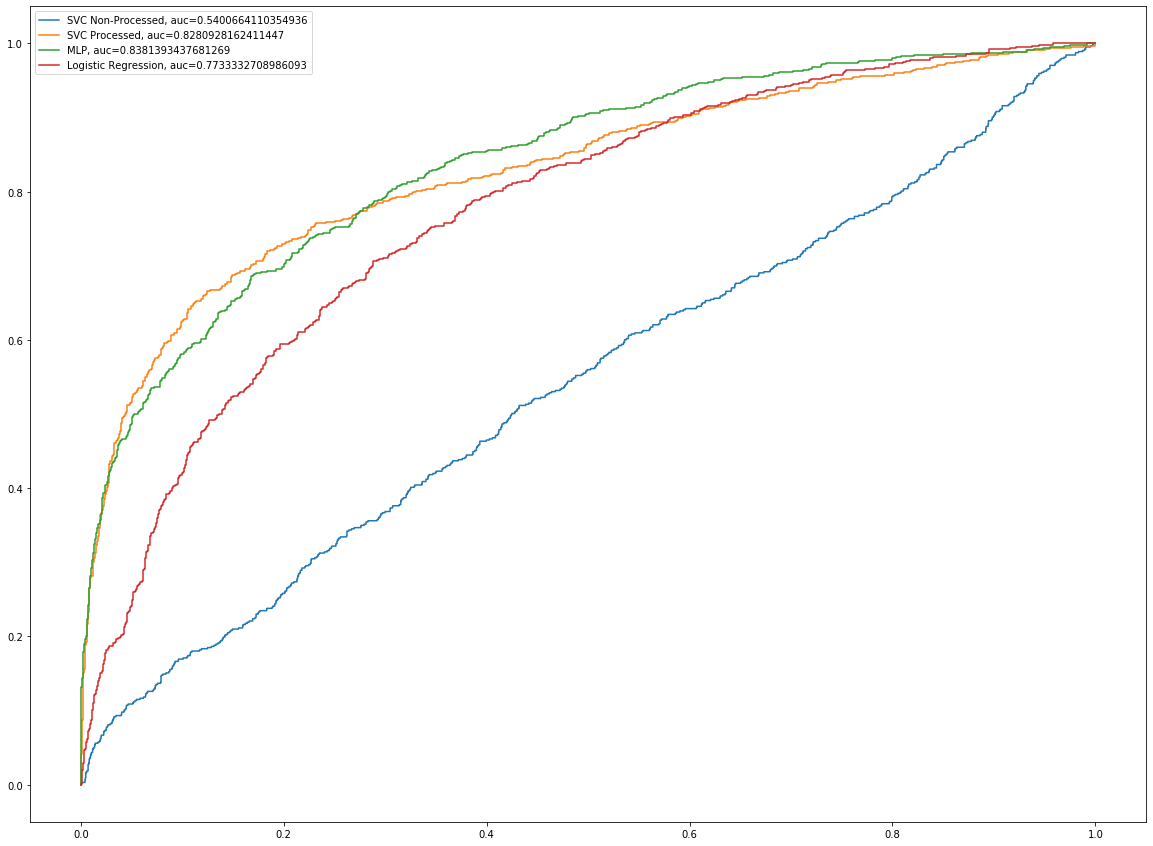

In [226]:
# Plot SVC ROC Curve
plt.figure(0, figsize=(20,15)).clf()

fpr_svc_npp, tpr_svc_npp, thresh_svc_npp = metrics.roc_curve(y_test_npp, y_score_svc_npp)
auc_svc_npp = metrics.roc_auc_score(y_test_npp, y_score_svc_npp)
plt.plot(fpr_svc_npp, tpr_svc_npp, label="SVC Non-Processed, auc=" + str(auc_svc_npp))

fpr_svc, tpr_svc, thresh_svc = metrics.roc_curve(y_test, y_score_svc)
auc_svc = metrics.roc_auc_score(y_test, y_score_svc)
plt.plot(fpr_svc, tpr_svc, label="SVC Processed, auc=" + str(auc_svc))

fpr_mlp, tpr_mlp, thresh_mlp = metrics.roc_curve(y_test, y_score_mlp)
auc_mlp = metrics.roc_auc_score(y_test, y_score_mlp)
plt.plot(fpr_mlp, tpr_mlp, label="MLP, auc=" + str(auc_mlp))

fpr_lr, tpr_lr, thresh_lr = metrics.roc_curve(y_test, y_score_lr)
auc_lr = metrics.roc_auc_score(y_test, y_score_lr)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression, auc=" + str(auc_lr))

plt.legend(loc=0)

In [79]:
filename = 'clf_svc.pkl'
pickle.dump(clf_svc, open(filename, 'wb'))
#!mkdir C:\Users\Palani\Downloads\model
!cp clf_svc.pkl C:\Users\Palani\Downloads
!tar -zcvf clf_svc.tar.gz clf_svc.pkl

clf_svc.pkl


In [80]:
from ibm_watson_machine_learning import APIClient

In [81]:
wml_credentials = {
    "url" : "https://eu-gb.ml.cloud.ibm.com",
    "apikey" : "Fxr2PcwnA3Gv9s6z2wqvuvLRH7eGviBb9ZptvZsWWgoE"
}

In [82]:
client = APIClient(wml_credentials)

In [83]:
metadata = {
    client.spaces.ConfigurationMetaNames.NAME:"Telecom Churn Prediction",
    client.spaces.ConfigurationMetaNames.DESCRIPTION:"To predict customers who can exit the company",
    client.spaces.ConfigurationMetaNames.STORAGE:{
        "type":"bmcos_object_storage",
        "resource_crn":"crn:v1:bluemix:public:cloud-object-storage:global:a/fb6fa763b6724d4a8396c30b43647ff1:aab26c6f-ee90-400a-8517-f7fc95364cea::"
    },
    client.spaces.ConfigurationMetaNames.COMPUTE:{
        "name":"WatsonMachineLearning",
        "crn":"crn:v1:bluemix:public:pm-20:eu-gb:a/fb6fa763b6724d4a8396c30b43647ff1:80c86e14-003d-4758-b77f-4cdaeddb4045::"
    },
}

In [84]:
space_details = client.spaces.store(meta_props=metadata)

Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)


In [85]:
space_details

{'entity': {'compute': [{'crn': 'crn:v1:bluemix:public:pm-20:eu-gb:a/fb6fa763b6724d4a8396c30b43647ff1:80c86e14-003d-4758-b77f-4cdaeddb4045::',
    'guid': '80c86e14-003d-4758-b77f-4cdaeddb4045',
    'name': 'WatsonMachineLearning',
    'type': 'machine_learning'}],
  'description': 'To predict customers who can exit the company',
  'members': [{'id': 'IBMid-5500092J0T',
    'role': 'admin',
    'state': 'active',
    'type': 'user'}],
  'name': 'Telecom Churn Prediction',
  'scope': {'bss_account_id': 'fb6fa763b6724d4a8396c30b43647ff1'},
  'status': {'state': 'preparing'}},
 'metadata': {'created_at': '2020-12-15T11:54:12.849Z',
  'creator_id': 'IBMid-5500092J0T',
  'id': 'fa0a78f1-0926-4f84-a46c-28ae25d621a5',
  'url': '/v2/spaces/fa0a78f1-0926-4f84-a46c-28ae25d621a5'}}

In [86]:
space_id = space_details["metadata"]["id"]
space_id

'fa0a78f1-0926-4f84-a46c-28ae25d621a5'

In [87]:
client.set.default_space(space_id)

'SUCCESS'

In [88]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029a-cc97-56da-b8e0-39c3880dbbe7  base
tensorflow_2.1-py3.6           1eb25b8

In [89]:
import sklearn
sklearn.__version__

'0.22.2'

In [90]:
spec_id = client.software_specifications.get_id_by_name("scikit-learn_0.22-py3.6")

In [91]:
model_details = client.repository.store_model(model=clf_svc,meta_props={
    client.repository.ModelMetaNames.NAME:"Churn Prediction",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:spec_id,
    client.repository.ModelMetaNames.TYPE:"scikit-learn_0.22"
})

Note: Warnings!! :  Model type scikit-learn_0.22 is deprecated. We recommend you use a supported model type. See Supported Frameworks https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html.


In [92]:
model_id = model_details["metadata"]["id"]
model_id

'71b85527-a0c1-4098-a85e-be94ba8c2c3a'

In [93]:
deployment_metadata = {
    client.deployments.ConfigurationMetaNames.NAME:"Telecom Churn Prediction Deployment",
    client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [96]:
deployment_details = client.deployments.create(artifact_uid=model_id, meta_props=deployment_metadata)



#######################################################################################

Synchronous deployment creation for uid: '71b85527-a0c1-4098-a85e-be94ba8c2c3a' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='bc8a241a-2b1d-4a1e-8cb1-d7215790f052'
------------------------------------------------------------------------------------------------




In [97]:
deployment_id = deployment_details["metadata"]["id"]

In [98]:
col = X.columns
col = list(col)
col

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Female',
 'Gender_Male']

In [99]:
#score_list = ['589','39','6','163520.37','3','1','0','75238.55','0','1','0','1','0']
score_list = ['850', '43', '2', '0.00', '1', '1', '1', '15000', '0', '0', '1', '0', '1']

In [100]:
payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA:[{
        "fields":col,
        "values":[score_list],
    }]
}

In [102]:
deployment_details = client.deployments.score(deployment_id=deployment_id, meta_props=payload)

In [103]:
deployment_details

{'predictions': [{'fields': ['prediction'], 'values': [[1]]}]}